In [1]:
import rdflib
import random
import pandas as pd
# from sklearn.cluster import KMeans


from knowledge_graph import *
# from rdf2vec import RDF2VecTransformer

from lcs_rdf_graph_2_sp_file import LCS

from rdf_graph_utils import rdf_to_plot, rdf_to_text

import gc, copy


def graph_len(g, depth=None):
    g = kg_to_rdflib(g, depth) if isinstance(g, KnowledgeGraph) else g
    return len(g)


def rdflib_to_kg_no_autoref(rdflib_g, label_predicates=[]):
    # Iterate over triples, add s, p and o to graph and 2 edges (s-->p, p-->o)
    # all predicates in label_predicates get excluded
    kg = KnowledgeGraph()
    for (s, p, o) in rdflib_g:
        if p not in label_predicates:
            if s != o:
                s_v, o_v = Vertex(str(s)), Vertex(str(o))
                p_v = Vertex(str(p), predicate=True)
                kg.add_vertex(s_v)
                kg.add_vertex(p_v)
                kg.add_vertex(o_v)
                kg.add_edge(s_v, p_v)
                kg.add_edge(p_v, o_v)
    return kg

In [2]:
print(end='Loading data... ', flush=True)
g = rdflib.Graph()

g.parse('../../datasets/InfluenceTracker/cluster_38-1_hm_ih_lvl2_part.nt', format="nt")
# g.parse('../../datasets/InfluenceTracker/full_dataset.nt', format="nt")
print('OK')
#
# # Extract all database accounts' URI
all_accounts_file = pd.read_csv('../../datasets/InfluenceTracker/IT_params/users_clusters/accounts_cluster_38-1.txt', sep='\t')
all_accounts = [rdflib.URIRef(x) for x in all_accounts_file['accounts']]
#
# # Define irrelevant predicates
predicates_file = pd.read_csv('../../datasets/InfluenceTracker/IT_params/IT_bad_predicates.tsv', sep='\t')
predicates = [rdflib.URIRef(x) for x in predicates_file['predicate']]
#
stop_patterns = pd.read_csv('../../datasets/InfluenceTracker/IT_params/IT_stop_patterns.tsv', sep='\t')
stop_patterns = [x for x in stop_patterns['stopping_patterns']]

stop_patterns_2 = pd.read_csv('../../datasets/InfluenceTracker/IT_params/IT_stop_patterns_2.tsv', sep='\t')
stop_patterns_2 = [x for x in stop_patterns_2['stopping_patterns']]

preds = []


Loading data... OK


In [3]:
search_dbpedia = False

if search_dbpedia:
    g_dbpedia = rdflib.Graph()
    g_dbpedia.parse("../../datasets/InfluenceTracker/dbpedia/cluster_38-1_dbpedia.nt", format="nt")
    
    mappings = {}
    with open("../../datasets/InfluenceTracker/dbpedia/dbpediaGraph.nt", "r") as f:
        for line in f.readlines():
            if not line.isspace():
                line = line.replace("<", "").replace(">", "")
                s, p, o, _ = line.split(" ")
                if p == "http://www.influencetracker.com/ontology#dbpediaUri":
                    mappings[o] = s
            

    
    for (s_db, p_db, o_db) in g_dbpedia:
        if str(s_db) in mappings.keys():
            new_subj = rdflib.term.URIRef(mappings[str(s_db)].replace("TwitterAccount", "User"))
            g.add((new_subj, p_db, o_db))
            
         

In [4]:
kg = rdflib_to_kg_no_autoref(g, label_predicates=predicates)


print("created kg")

del g
gc.collect()


#
# # %%
# # estraggo un'istanza di knowledge graph per ogni account presente in quello iniziale

kg_depth = 2

i = 0
j = 0

kv = {}
accounts = []
graphs = []

for account in all_accounts:
    try:
        gi = extract_instance(kg, account, kg_depth)
        graphs.append(gi)
        accounts.append(account)
        # kv.append({'graph': gi, 'resource': account})
        kv[str(account)] = i
   
        i += 1
    except Exception as e:
        j += 1

print('ok:' + str(i))
print('not imported: ' + str(j))

del kg
gc.collect()


    

created kg
ok:9
not imported: 0


0

In [5]:
cluster = []
clusters = {}
index_to_name = {}
resources = []
path_cluster = "../../datasets/InfluenceTracker/data/cluster_line_38-1"

with open(path_cluster, "r") as f:
    lines = f.readlines()
    for line in lines:
        line = line.replace("TwitterAccount", "User").strip()
        if line in kv.keys():
            cluster.append(kv[line])
            index_to_name[kv[line]] = line



'\n# # Embeddings\ntransformer = RDF2VecTransformer(wl=False, max_path_depth=2, vector_size=15, walks_per_graph=4)\n# transformer = RDF2VecTransformer()\ntransformer.fit(graphs, accounts)\nembeddings = transformer.transform(graphs, accounts)\n\n\n\n #%%\n\n# STAMPO PER OGNI RISORSA IL CLUSTER A CUI CORRISPONDE, IN MODO DA POTERNE PRELEVARE PER IL MOMENTO\n# DUE APPARTENENTI ALLO STESSO CLUSTER\nkmeans = KMeans(n_clusters=10)\nkm = kmeans.fit(embeddings)\ny_kmeans = kmeans.predict(embeddings)\n\nprint("clustering models created")\n\n #%%\n\n\nclusters = {i: [] for i in range(kmeans.n_clusters)}\ni = 0\nfor j in y_kmeans:\n    clusters[j].append(i)\n    i += 1\n\n\n\n #%%\nclusters = {}\n# Print clusters and their dimension\n\nfor key in clusters.keys():\n    print("cluster " + str(key) + " with dimension: " + str(len(clusters[key])))\n\n'

In [6]:
# print(list(kv.keys())[list(kv.values()).index(0)])

for i in range(len(cluster)):
    print(str(i) + " " + list(kv.keys())[list(kv.values()).index(i)] + " con dim " + str(len(kg_to_rdflib(graphs[i], kg_depth))))

directory = "../../outputs/IT/oAccounts_cluster_38-1"

if not os.path.exists(directory):
    os.mkdir(directory)


# cluster da analizzare
k = 45

clusters[k] = cluster

clusters[k] = sorted(clusters[k],  key=lambda res: len(kg_to_rdflib(graphs[res], kg_depth)))

# clusters[k] = [48, 50]

L = len(clusters[k])

print("esploro il cluster: " + str(k) + " con dimensione " + str(L))

# risorsa iniziale
# resource_1 = random.choice(clusters[k])

resource_1 = clusters[k].pop(0)
graph_1 = graphs[resource_1]


# clusters[k].remove(resource_1)
explored_resources = [resource_1]


iteration = 0


0 http://www.influencetracker.com/resource/User/airbnb con dim 274
1 http://www.influencetracker.com/resource/User/britneyspears con dim 763
2 http://www.influencetracker.com/resource/User/twitter con dim 845
3 http://www.influencetracker.com/resource/User/fortunemagazine con dim 160
4 http://www.influencetracker.com/resource/User/yahoo con dim 206
5 http://www.influencetracker.com/resource/User/theellenshow con dim 480
6 http://www.influencetracker.com/resource/User/whitehouse con dim 464
7 http://www.influencetracker.com/resource/User/pinterest con dim 185
8 http://www.influencetracker.com/resource/User/billgates con dim 658
esploro il cluster: 45 con dimensione 9
risorsa iniziale: 3 di dim -> 125


In [7]:
# file = open(directory + "/tmp_LCS.log", "a")

while clusters[k] and graph_len(graph_1, kg_depth) > 0:
    # try:
        file = open(directory + "/tmp_LCS.log", "a")
        
        # resource_2 = random.choice(clusters[k])
   
        resource_2 = clusters[k].pop(0)
        graph_2 = graphs[resource_2]
        print("LCS with resource: " + str(resource_2) 
              + " con dim: " + str(graph_len(graph_2, kg_depth)))
        # clusters[k].remove(resource_2)

        # seed
        seed = LCS(graph_1, graph_2, depth=2, stop_patterns=stop_patterns, uninformative_triples=preds, additional_stop_patterns=stop_patterns_2)
        seed.find()
              
        explored_resources.append(resource_2)
        
        print("dim LCS itermedio tra " + str(explored_resources) + " \n--> " + str(graph_len(seed)))
        
        del graph_1
        del graph_2
        gc.collect()
        
        graph_1 = copy.deepcopy(seed)

        print("Iterazione: " + str(iteration) + ", trovato LCS tra: " + str(explored_resources))
        rdf_to_text(seed, directory, "turtle", "tmp_LCS_" + str(iteration))
        rdf_to_text(seed, directory, "nt", "tmp_LCS_" + str(iteration))
        
        del seed
        gc.collect()
        
        file.write("Iterazione: " + str(iteration) +  " risorse esplorate: " + str(explored_resources) + "\n")
        file.close()
        
        iteration += 1
        """
        except Exception as e:
            print("got exception: " + str(e))
            file.close()
        """
# file.close()



LCS with resource: 4 con dim: 206
starting graphs exploration...
exploration ended.
filling LCS graph.
graph completed.
dim LCS itermedio tra [3, 7, 4] 
--> 0
Iterazione: 0, trovato LCS tra: [3, 7, 4]


#### plotting graph ####
LCS finale tra le risorse: [3, 7, 4]


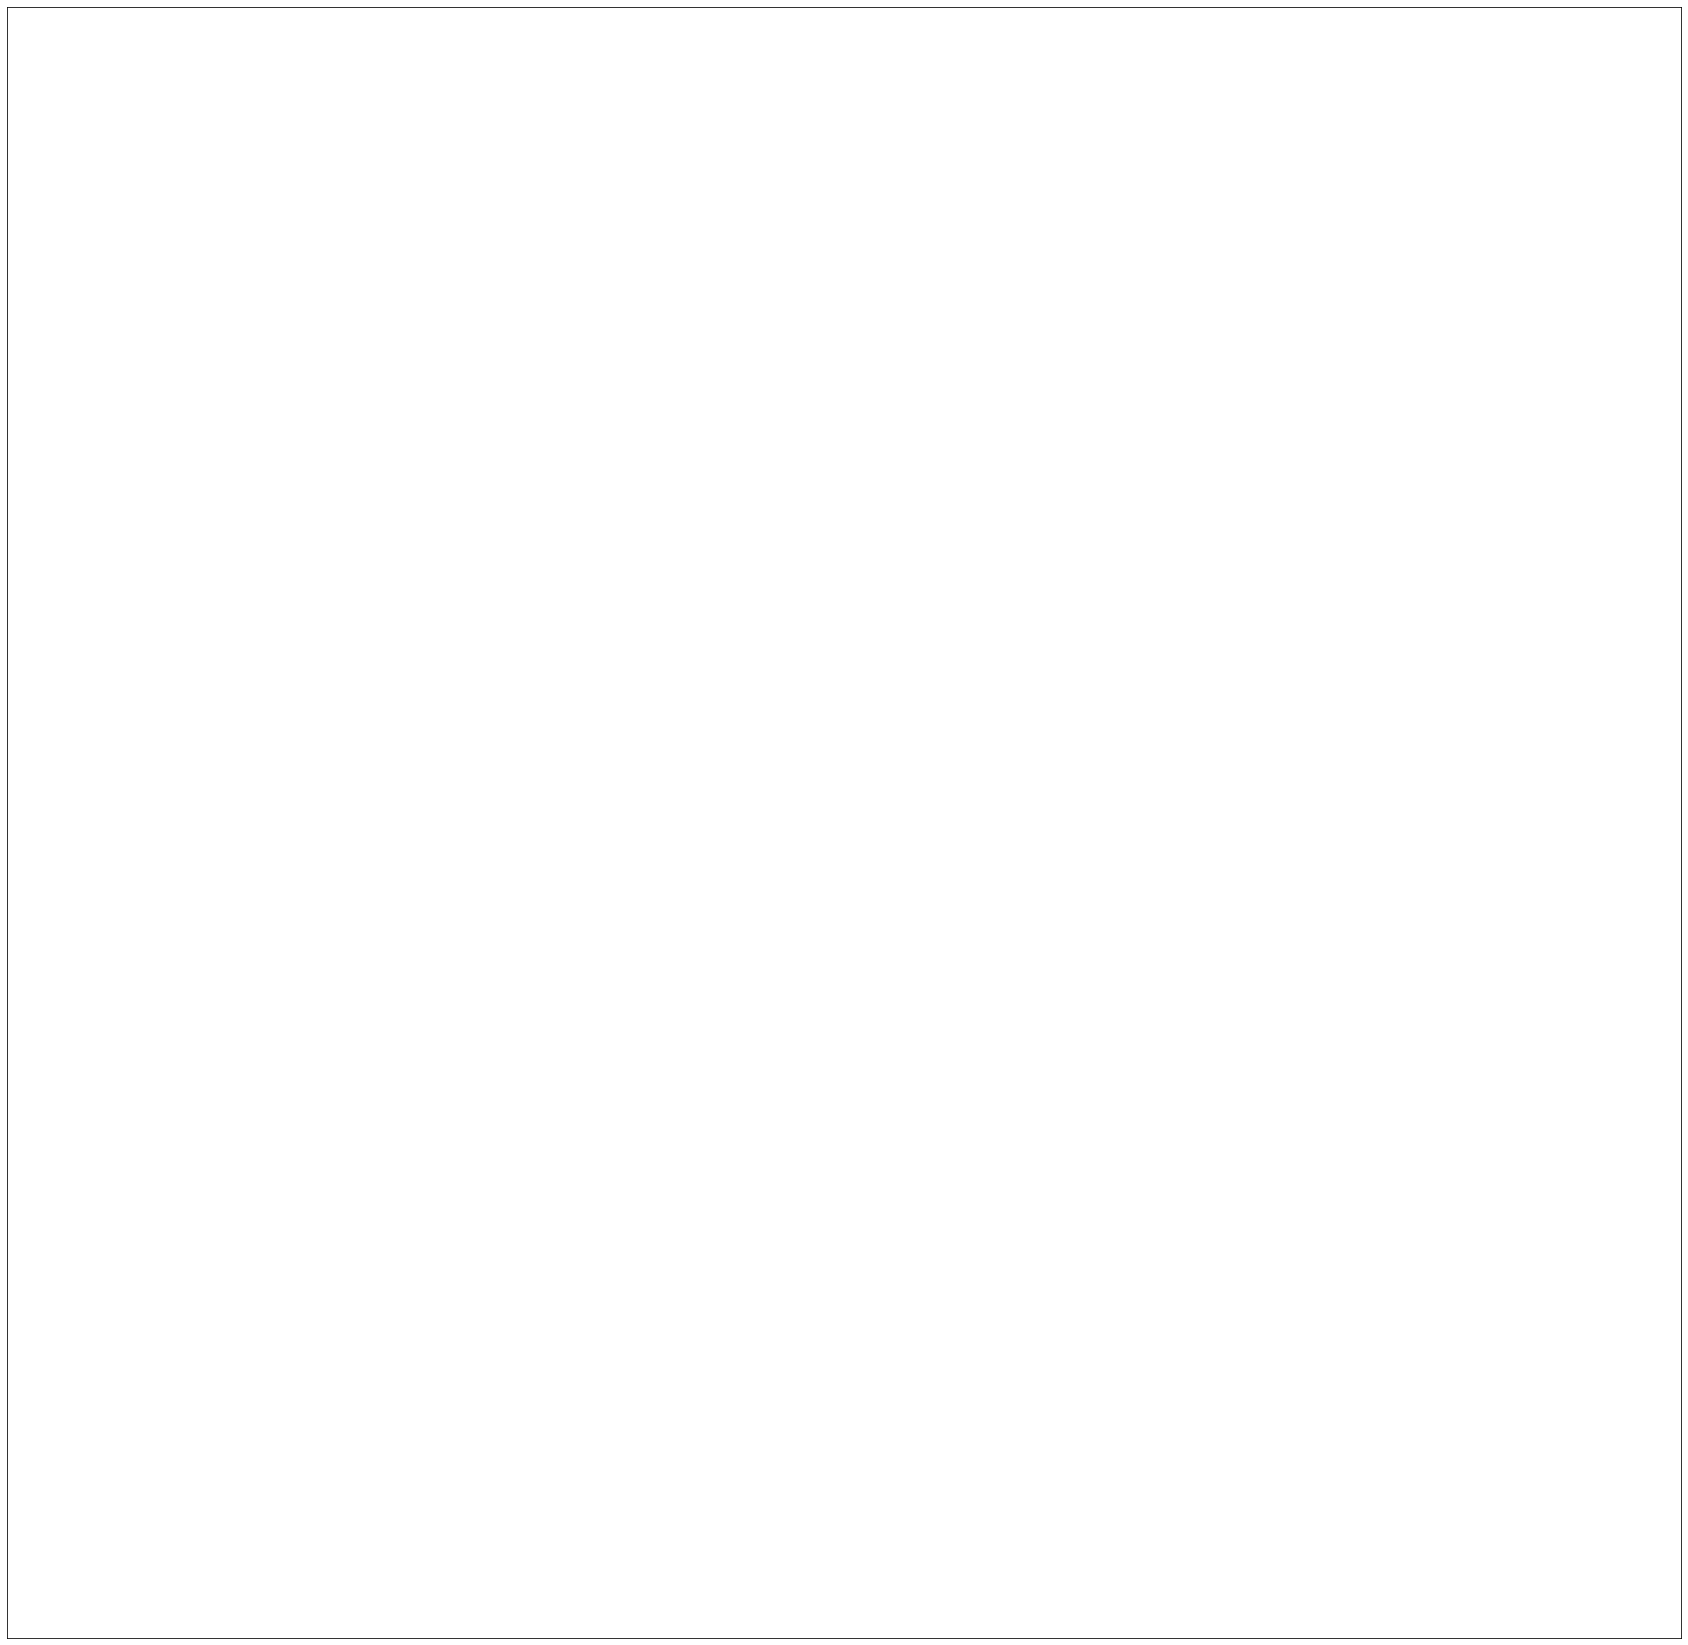

In [8]:
rdf_to_plot(graph_1, directory)
print("LCS finale tra le risorse: " + str(explored_resources))

In [9]:
# SALVATAGGIO DEL GRAFO

rdf_to_text(graph_1, directory, 'turtle', 'final_LCS')
rdf_to_text(graph_1, directory, 'nt', 'final_LCS')
file =  open(directory + "/final_LCS_resources.log", "a")
file.write(str(explored_resources))



9

In [10]:

file.write("\n ####### \n")

explored_resources_names = []

for account_index in explored_resources:
    account_name = index_to_name[account_index]
    explored_resources_names.append(account_name)

file.write(str(explored_resources_names))
file.close()
